In [22]:
# Importação de bibliotecas

import os
import sys
import pandas as pd
import numpy as np
import polars as pl
import re
import spacy
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from bertopic import BERTopic
from transformers import BertTokenizer, BertForMaskedLM, DataCollatorForLanguageModeling, Trainer, TrainingArguments, BertModel
import torch
from datasets import Dataset
from umap import UMAP
import plotly.express as px
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [23]:
# Definicao da raiz do projeto

PROJECT_ROOT = 'G:/Csouza/nlp/topic_modeling'

os.chdir(PROJECT_ROOT)

sys.path.insert(0, PROJECT_ROOT)

In [24]:
def extract(extract_path, file_name='all_process.xlsx', sheet_name='Sheet1'):
    
    return pl.read_excel(f'{extract_path}/{file_name}', sheet_name=sheet_name)

In [25]:
data_path = os.path.join(PROJECT_ROOT, 'data', 'internal', 'fapesp_projects')

full_data = extract(data_path)

variables = {
'N. Processo_B.V': 'n_processo',
'Data de Início': 'data',
'Título (Português)': 'titulo',
'Grande Área do Conhecimento': 'grande_area',
'Área do Conhecimento': 'area',
'Subárea do Conhecimento': 'subarea',
'Palavras-Chave do Processo': 'palavras_chave',
'Assuntos': 'assuntos',
'Resumo (Português)': 'resumo'}

full_data = (
    full_data
    .lazy()
    .rename(variables)
    .select(variables.values())
    .filter(
        pl.col('n_processo').is_not_null(),
        pl.col('resumo').is_not_null(),
        pl.col('resumo') != '')
    .with_columns(
        pl.col('data').str.to_datetime('%m-%d-%y').dt.year().alias('ano'),
        pl.col('data').str.to_datetime('%m-%d-%y').dt.month().alias('mes'))
    .select(pl.exclude('data'))
).collect()

full_data.head(3)

n_processo,titulo,grande_area,area,subarea,palavras_chave,assuntos,resumo,ano,mes
str,str,str,str,str,str,str,str,i32,i8
"""95/04916-0""","""Estudo sistemático de campos h…","""Ciências Exatas e da Terra""","""Física""","""Física da Matéria Condensada""","""CORRELACAO ANGULAR, ESTUDO SIS…",null,"""Este projeto está vinculado ao…",1995,12
"""95/05064-7""","""Cultura, ideologia e represent…","""Ciências Humanas""","""Sociologia""","""Outras Sociologias Específicas""","""BRASIL, IDENTIDADE, PENSAMENTO…","""Brasil:Identidade social""","""Participar do Seminário """"Soci…",1995,12
"""95/09836-4""","""Bernard Schmitt | Université d…","""Ciências Exatas e da Terra""","""Probabilidade e Estatística""","""Probabilidade""","""COMPRESSOR, ENTROPIA, ESTADO D…","""Entropia (matemática aplicada)…","""O principal objetivo da visita…",1995,12


In [26]:
data_train_test = full_data.filter(pl.col('assuntos').is_not_null(), pl.col('area') == 'Medicina')

data_train_test.shape

(17342, 10)

In [27]:
def get_spacy_model(model='en_core_web_sm'):
    """
    Baixa o modelo de linguagem spaCy se não estiver presente.
    """
    try:
        nlp = spacy.load(model)
    except OSError:
        from spacy.cli import download
        download(model)
        nlp = spacy.load(model)
    return nlp

# Carregar o modelo de linguagem em português do spaCy
nlp = get_spacy_model('pt_core_news_sm')

# Definir as stop words em português usando spaCy
stop_words = nlp.Defaults.stop_words

# Compilador para remover caracteres especiais (exceto acentos e espaços)
special_char_remover = re.compile(r'[^A-Za-zÀ-ÿ\s]')

def clean_text(text):
    if not isinstance(text, str):
        raise ValueError("O argumento 'text' deve ser uma string.")
    
    # Remover caracteres especiais
    text = special_char_remover.sub('', text)
    
    # Tokenizar o texto e remover stop words
    tokens = [token.text for token in nlp(text) if token.text not in stop_words]
    
    # Lematizar o texto
    doc = nlp(' '.join(tokens))
    text = ' '.join([token.lemma_ for token in doc])

    return text

# Carregar os dados
data = data_train_test.to_pandas()

data['titulo'] = data['titulo'].astype(str)
data['palavras_chave'] = data['palavras_chave'].astype(str)

data['cleaned_text'] = data['resumo'].apply(clean_text)
data['cleaned_text'] += ' ' + data['titulo'].apply(clean_text) + ' ' + data['palavras_chave'].apply(clean_text)

In [ ]:
tokenizer = BertTokenizer.from_pretrained('neuralmind/bert-base-portuguese-cased')
bert_model = BertForMaskedLM.from_pretrained('neuralmind/bert-base-portuguese-cased')

# Função de tokenização para MLM
def tokenize_function(examples):
    return tokenizer(examples['cleaned_text'], padding="max_length", truncation=True, max_length=128)

dataset = Dataset.from_pandas(data)
tokenized_datasets = dataset.map(tokenize_function, batched=True)

# Dividir em conjunto de treino e teste
train_test_split = tokenized_datasets.train_test_split(test_size=0.2)
train_dataset = train_test_split['train']
test_dataset = train_test_split['test']

# Data collator para MLM (vai automaticamente mascarar tokens)
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=True, mlm_probability=0.15)

Some weights of the model checkpoint at neuralmind/bert-base-portuguese-cased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Map: 100%|██████████| 290/290 [00:00<00:00, 357.59 examples/s]


In [ ]:
data['word_count'] = data['cleaned_text'].apply(lambda x: len(x.split()))
fig = px.histogram(data, x='word_count', nbins=30, title='Distribuição da Contagem de Palavras por Documento')
fig.show()

In [ ]:
all_words = ' '.join(data['cleaned_text']).split()
word_freq = Counter(all_words)
common_words = word_freq.most_common(20)

words, counts = zip(*common_words)
word_freq_df = pd.DataFrame({'Palavra': words, 'Frequência': counts})

fig = px.bar(word_freq_df, x='Frequência', y='Palavra', orientation='h', title='Top 20 Palavras Mais Frequentes')
fig.show()

In [ ]:
vectorizer = CountVectorizer(ngram_range=(2, 2)).fit(data['cleaned_text'])
bigrams = vectorizer.transform(data['cleaned_text'])
bigram_freq = zip(vectorizer.get_feature_names_out(), bigrams.sum(axis=0).tolist()[0])
bigram_freq = sorted(bigram_freq, key=lambda x: x[1], reverse=True)[:20]

bigrams, counts = zip(*bigram_freq)
bigram_freq_df = pd.DataFrame({'Bigramas': bigrams, 'Frequência': counts})

fig = px.bar(bigram_freq_df, x='Frequência', y='Bigramas', orientation='h', title='Top 20 Bigramas Mais Frequentes')
fig.show()


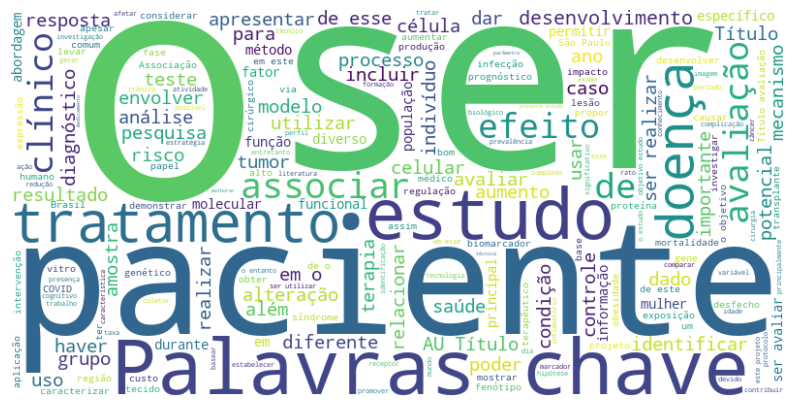

In [ ]:
text = ' '.join(data['cleaned_text'])
wordcloud = WordCloud(width=800, height=400, background_color ='white').generate(text)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


In [ ]:
def train_model(model, tokenizer, train_dataset, test_dataset, data_collator, model_path, tokenizer_path, output_dir, overwrite_output_dir=True, save_steps=10_000, save_total_limit=2, prediction_loss_only=True, num_train_epochs=3, per_device_train_batch_size=8):    
    
    os.makedirs(model_path, exist_ok=True)
    os.makedirs(tokenizer_path, exist_ok=True)

    training_args = TrainingArguments(
        output_dir=output_dir,
        overwrite_output_dir=overwrite_output_dir,
        num_train_epochs=num_train_epochs,
        per_device_train_batch_size=per_device_train_batch_size,
        save_steps=save_steps,
        save_total_limit=save_total_limit,
        prediction_loss_only=prediction_loss_only,
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        data_collator=data_collator,
        train_dataset=train_dataset,
        eval_dataset=test_dataset,
    )

    # Treinar o modelo
    trainer.train()

    # Salvar o modelo e o tokenizer
    if model_path:
        trainer.save_model(model_path)
    
    if tokenizer_path:
        tokenizer.save_pretrained(tokenizer_path)
    
    return trainer

def evaluate_model(trainer, test_dataset, metric_average='weighted'):

    predictions, labels, _ = trainer.predict(test_dataset)
    preds = predictions.argmax(axis=1)
    
    accuracy = accuracy_score(labels, preds)
    precision = precision_score(labels, preds, average=metric_average)
    recall = recall_score(labels, preds, average=metric_average)
    f1 = f1_score(labels, preds, average=metric_average)
    
    metrics = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1
    }
    
    return metrics

def extract_embeddings(texts, model, tokenizer, batch_size=8):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    model.eval()
    all_embeddings = []
    
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i + batch_size]
        inputs = tokenizer(batch_texts, padding=True, truncation=True, return_tensors="pt").to(device)
        with torch.no_grad():
            outputs = model(**inputs)
        batch_embeddings = outputs.last_hidden_state.mean(dim=1)
        all_embeddings.append(batch_embeddings.cpu())
    
    all_embeddings = torch.cat(all_embeddings, dim=0)
    return all_embeddings

def save_embeddings(embeddings, embeddings_path):
    np.save(embeddings_path, embeddings)
    
def load_embeddings(embeddings_path):
    if os.path.exists(embeddings_path):
        return np.load(embeddings_path)
    else:
        raise FileNotFoundError(f'Embeddings file not found at {embeddings_path}')

def train_bertopic(docs, clean_text=None, use_embeddings=False, precomputed_embeddings=None, bert_model=None, tokenizer=None, umap_n_neighbors=15, umap_n_components=5, umap_min_dist=0.0, umap_metric='cosine', vectorizer_ngram_range=(1, 2), stop_words=stop_words):
    if clean_text:
        docs = [clean_text(doc) for doc in docs]
    
    if not isinstance(stop_words, list):
        stop_words = list(stop_words)
    
    umap_model = UMAP(n_neighbors=umap_n_neighbors, n_components=umap_n_components, min_dist=umap_min_dist, metric=umap_metric)
    vectorizer_model = CountVectorizer(ngram_range=vectorizer_ngram_range, stop_words=stop_words)
    
    if use_embeddings:
        embeddings = precomputed_embeddings
        if embeddings is None:
            assert bert_model is not None, "O modelo deve ser fornecido quando use_embeddings=True"
            assert tokenizer is not None, "O tokenizador deve ser fornecido quando use_embeddings=True"
            embeddings = extract_embeddings(docs, bert_model, tokenizer)
        topic_model = BERTopic(umap_model=umap_model, vectorizer_model=vectorizer_model)
        topic_model.fit(docs, embeddings)
    else:
        topic_model = BERTopic(umap_model=umap_model, vectorizer_model=vectorizer_model)
        topic_model.fit(docs)
    
    return topic_model

In [ ]:
model_path = os.path.join(PROJECT_ROOT, 'models')
tokenizer_path = os.path.join(PROJECT_ROOT, 'tokenizers')
results_path = os.path.join(model_path, 'results')

model_full_path = os.path.isfile(os.path.join(model_path, 'pytorch_model.bin'))
tokzr_full_path = os.path.isfile(os.path.join(tokenizer_path, 'vocab.txt'))

if not model_full_path or not tokzr_full_path:
    trainer = train_model(
        model=bert_model,
        tokenizer=tokenizer,
        train_dataset=train_dataset,
        test_dataset=test_dataset,
        data_collator=data_collator,
        model_path=model_path,
        tokenizer_path=tokenizer_path,
        output_dir=results_path
    )

    metrics = evaluate_model(trainer, test_dataset)
    print("Metrics:", metrics)

In [ ]:
tokenizer = BertTokenizer.from_pretrained(tokenizer_path)
bert_model = BertModel.from_pretrained(model_path)

In [ ]:
bertopic_name = f'{model_path}/bertopic_model.pt'

if not os.path.exists(bertopic_name):
    text_train = train_dataset['cleaned_text'].tolist()
    bertopic_model = train_bertopic(docs=text_train)
    bertopic_model.save(bertopic_name)

bertopic_model = BERTopic.load(bertopic_name)
bertopic_model.visualize_topics()

In [ ]:
embeddings_name = f'{model_path}/bertimbal_embeddings.npy'
if not os.path.exists(embeddings_name):
    text_embeddings = train_dataset['cleaned_text'].tolist()
    embeddings = extract_embeddings(text_embeddings, bert_model, tokenizer)
    save_embeddings(embeddings, embeddings_name)

embeddings = load_embeddings(embeddings_name)

bertopic_bertimbal_embeddings_name = f'{model_path}/bertopic_bertimbal_embeddings_model.pt'
if not os.path.exists(bertopic_bertimbal_embeddings_name):
    text_train = train_dataset['cleaned_text'].tolist()
    bertopic_bertimbal_embeddings_model = train_bertopic(docs=text_train, use_embeddings=True, precomputed_embeddings=embeddings)
    bertopic_bertimbal_embeddings_model.save(bertopic_bertimbal_embeddings_name)

bertopic_bertimbal_embeddings_model = BERTopic.load(bertopic_bertimbal_embeddings_name)
bertopic_bertimbal_embeddings_model.visualize_topics()